In [1]:
#import necessary python libraries
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant


In [51]:
#Download the data
start_date='2022-04-01'

end_date=pd.to_datetime(start_date)+pd.DateOffset(365*2)

assets=yf.download('AAPL', start=start_date, end=end_date)

assets.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-01,174.029999,174.880005,171.940002,174.309998,171.908112,78751300
2022-04-04,174.570007,178.490005,174.440002,178.440002,175.981201,76468400
2022-04-05,177.500000,178.300003,174.419998,175.059998,172.647781,73401800
2022-04-06,172.360001,173.630005,170.130005,171.830002,169.462296,89058800
2022-04-07,171.160004,173.360001,169.850006,172.139999,169.768005,77594700


In [52]:
#Read the Fama-French 3-factor data which was downloaded from Kenneth French Website
factors=pd.read_csv(r"C:\Users\User\OneDrive\Desktop\F-F_Research.csv", index_col=0, skipfooter=3, engine='python')

factors.index=pd.to_datetime(factors.index, format='%Y%m%d')

# Convert factors to decimals, but skip RF if needed
factors[['Mkt-RF', 'SMB', 'HML']] = factors[['Mkt-RF', 'SMB', 'HML']] / 100

print(factors['RF'].head())


1926-07-01    0.009
1926-07-02    0.009
1926-07-06    0.009
1926-07-07    0.009
1926-07-08    0.009
Name: RF, dtype: float64


In [53]:
#convert the asset prices to returns
assets['Returns']=assets['Adj Close'].pct_change().dropna()

data=pd.merge(assets['Returns'],factors, left_index=True, right_index=True)

data['RF']

2022-04-01    0.001
2022-04-04    0.001
2022-04-05    0.001
2022-04-06    0.001
2022-04-07    0.001
              ...  
2024-03-22    0.021
2024-03-25    0.021
2024-03-26    0.021
2024-03-27    0.021
2024-03-28    0.021
Name: RF, Length: 500, dtype: float64

In [71]:
%%capture
print(data.isnull().sum())
data.dropna()

print(np.isinf(data).sum())
data = data.replace([np.inf, -np.inf], np.nan).dropna()

from numpy.linalg import cond
print(cond(data.values))

correlation_matrix=data.corr()
print(correlation_matrix)

In [70]:
#Estimate Factor Exposures
X=add_constant(data[['Mkt-RF','SMB','HML']])

y=data['Returns']-data['RF']

# y.dropna()

# X = X.loc[y.index]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X_scaled)).fit()

print(model.summary())

#Get the estimated coefficients of the factors as betas
betas=model.params

print(betas)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     223.5
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           1.22e-91
Time:                        06:17:56   Log-Likelihood:                 1488.5
No. Observations:                 499   AIC:                            -2969.
Df Residuals:                     495   BIC:                            -2952.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0149      0.001    -27.043      0.0

In [78]:
betas=betas[:X.shape[1]]

expected_returns=np.dot(X,betas)

data['Expected Returns']=expected_returns

data=data.copy()

In [80]:
# Identify mispricing: If actual return > expected return, the asset may be undervalued (long); otherwise, overvalued (short)
data['Mispricing']=data['Returns']-data['Expected Returns']

data['Signal']=np.where(data['Mispricing']>0,'Long','Short')

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns


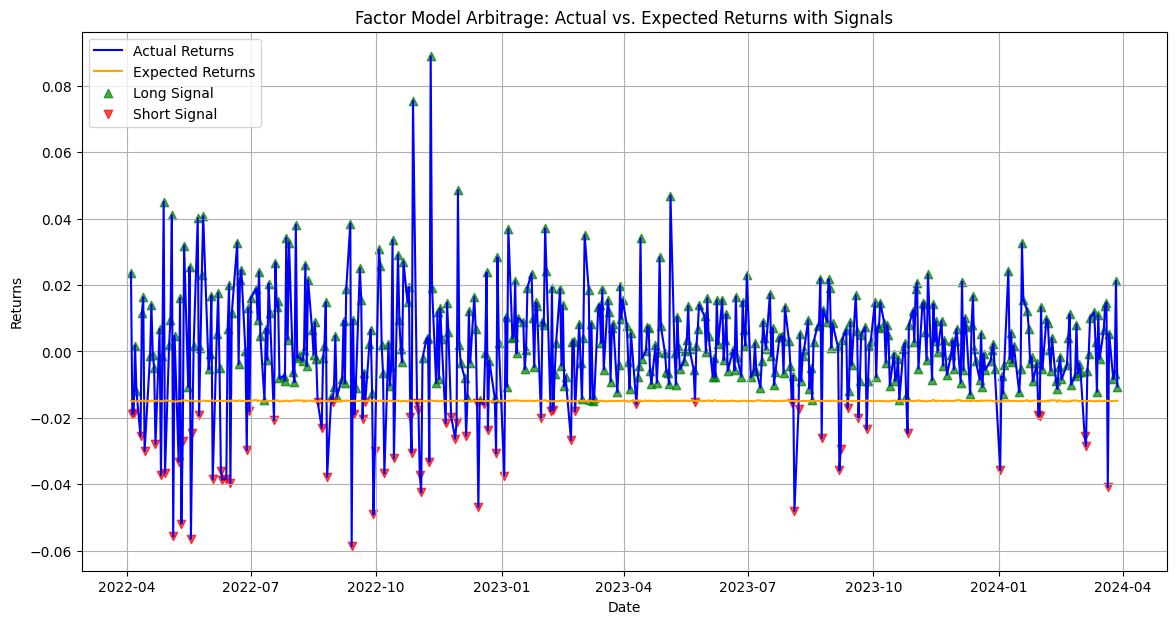

In [82]:
# Set up the plot
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Returns'], label='Actual Returns', color='blue')
plt.plot(data.index, data['Expected Returns'], label='Expected Returns', color='orange')

# Highlight the signals
long_signals = data[data['Signal'] == 'Long']
short_signals = data[data['Signal'] == 'Short']

# Plot Long signals
plt.scatter(long_signals.index, long_signals['Returns'], marker='^', color='green', label='Long Signal', alpha=0.7)

# Plot Short signals
plt.scatter(short_signals.index, short_signals['Returns'], marker='v', color='red', label='Short Signal', alpha=0.7)

# Customize the plot
plt.title('Factor Model Arbitrage: Actual vs. Expected Returns with Signals')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.grid(True)

# Show the plot
plt.show()
